In [1]:
import pandas as pd
import numpy as np
import time
import warnings
warnings.filterwarnings("ignore")

In [2]:
t0=time.time()
df = pd.read_csv('lending-club-loan-data/loan.csv')
t1=time.time()
print('Read time: {}'.format(t1-t0))
warnings.filterwarnings("ignore")

Read time: 86.94256091117859


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2260668 entries, 0 to 2260667
Columns: 145 entries, id to settlement_term
dtypes: float64(105), int64(4), object(36)
memory usage: 2.4+ GB


In [4]:
df.columns

Index(['id', 'member_id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv',
       'term', 'int_rate', 'installment', 'grade', 'sub_grade',
       ...
       'hardship_payoff_balance_amount', 'hardship_last_payment_amount',
       'disbursement_method', 'debt_settlement_flag',
       'debt_settlement_flag_date', 'settlement_status', 'settlement_date',
       'settlement_amount', 'settlement_percentage', 'settlement_term'],
      dtype='object', length=145)

In [5]:
df_cols = list(df.columns)

### The following variables have almost 90% null values, however upon closer inspection it becomes clear that many of the same rows possess non-null values, indicating that they are not missing at random. In fact after consulting the data dictionary, the columns are in fact values that many bank accounts simply don't possess therefore the rows with missing values should be converted to zeros, rather than dropping the columns. 

In [7]:
variables=['open_acc_6m', 'open_il_12m', 'open_il_24m', 'mths_since_rcnt_il',\
           'total_bal_il', 'il_util', 'open_rv_12m', 'open_rv_24m', 'max_bal_bc',\
           'all_util', 'inq_fi', 'total_cu_tl', 'inq_last_12m','collections_12_mths_ex_med',\
           'tot_coll_amt', 'tot_cur_bal', 'total_rev_hi_lim', 'revol_util','open_act_il' ]
for var in variables:
    df[var]=df[var].replace(np.nan,0)

### The following variables contain a small number of rows with null values, considering that imputation wouldn't affect the frequency distribution much, and potentially save a lot of signal from the other columns of those rows, the mode is imputed for the null values:

In [8]:
variables1=['acc_now_delinq', 'open_acc', 'total_acc','pub_rec','delinq_2yrs','inq_last_6mths','earliest_cr_line']
for var1 in df[variables1]:
    df[var1]=df[var1].replace(np.nan, df[var1].mode())

### The following variables are similar to those earlier in that they possess a lot of null values not missing at random. However in this it makes sense to encode them as binary since the data within the non-null rows is so unevenly distributed.

In [7]:
df.loc[(df.mths_since_last_delinq.notnull()),'delinq']=1
df.loc[(df.mths_since_last_delinq.isnull()),'delinq']=0

df.loc[(df.mths_since_last_major_derog.notnull()),'derog']=1
df.loc[(df.mths_since_last_major_derog.isnull()),'derog']=0

df.loc[(df.mths_since_last_record.notnull()),'public_record']=1
df.loc[(df.mths_since_last_record.isnull()),'public_record']=0

df.loc[(df.mths_since_rcnt_il.notnull()), 'rcnt_il']=1
df.loc[(df.mths_since_rcnt_il.isnull()), 'rcnt_il']=0

df.loc[(df.mths_since_recent_bc.notnull()), 'rcnt_bc']=1
df.loc[(df.mths_since_recent_bc.isnull()), 'rcnt_bc']=0

df.loc[(df.mths_since_recent_bc_dlq.notnull()), 'rcnt_bc_delinq']=1
df.loc[(df.mths_since_recent_bc_dlq.isnull()), 'rcnt_bc_delinq']=0

df.loc[(df.mths_since_recent_inq.notnull()), 'rcnt_inq']=1
df.loc[(df.mths_since_recent_inq.isnull()), 'rcnt_inq']=0

df.loc[(df.mths_since_recent_revol_delinq.notnull()), 'rcnt_revol_delinq']=1
df.loc[(df.mths_since_recent_revol_delinq.isnull()), 'rcnt_revol_delinq']=0

df.drop(['mths_since_last_delinq','mths_since_last_major_derog','mths_since_last_record','mths_since_rcnt_il',\
         'mths_since_recent_bc','mths_since_recent_bc_dlq','mths_since_recent_inq','mths_since_recent_revol_delinq'\
        ],axis=1,inplace=True)

In [8]:
df_cols = list(df.columns)

### The following columns are either irrelevent or leak data into the target variable and thus are dropped:

In [9]:
cols_to_drop = ['funded_amnt', 'funded_amnt_inv','zip_code', 'out_prncp', 'out_prncp_inv',\
                'total_pymnt','total_pymnt_inv', 'total_rec_prncp', 'debt_settlement_flag',\
                'total_rec_late_fee', 'recoveries', 'collection_recovery_fee','last_pymnt_d',\
                'last_pymnt_amnt', 'last_credit_pull_d','total_rec_int','hardship_flag',\
                'chargeoff_within_12_mths','next_pymnt_d','issue_d','pymnt_plan','emp_title',\
                'policy_code', 'title']

# dropping the columns listed above  
df = df.drop(cols_to_drop, axis=1)

In [10]:
df_nulls = df.isnull().sum()

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

### Inspecting the remaining null values:

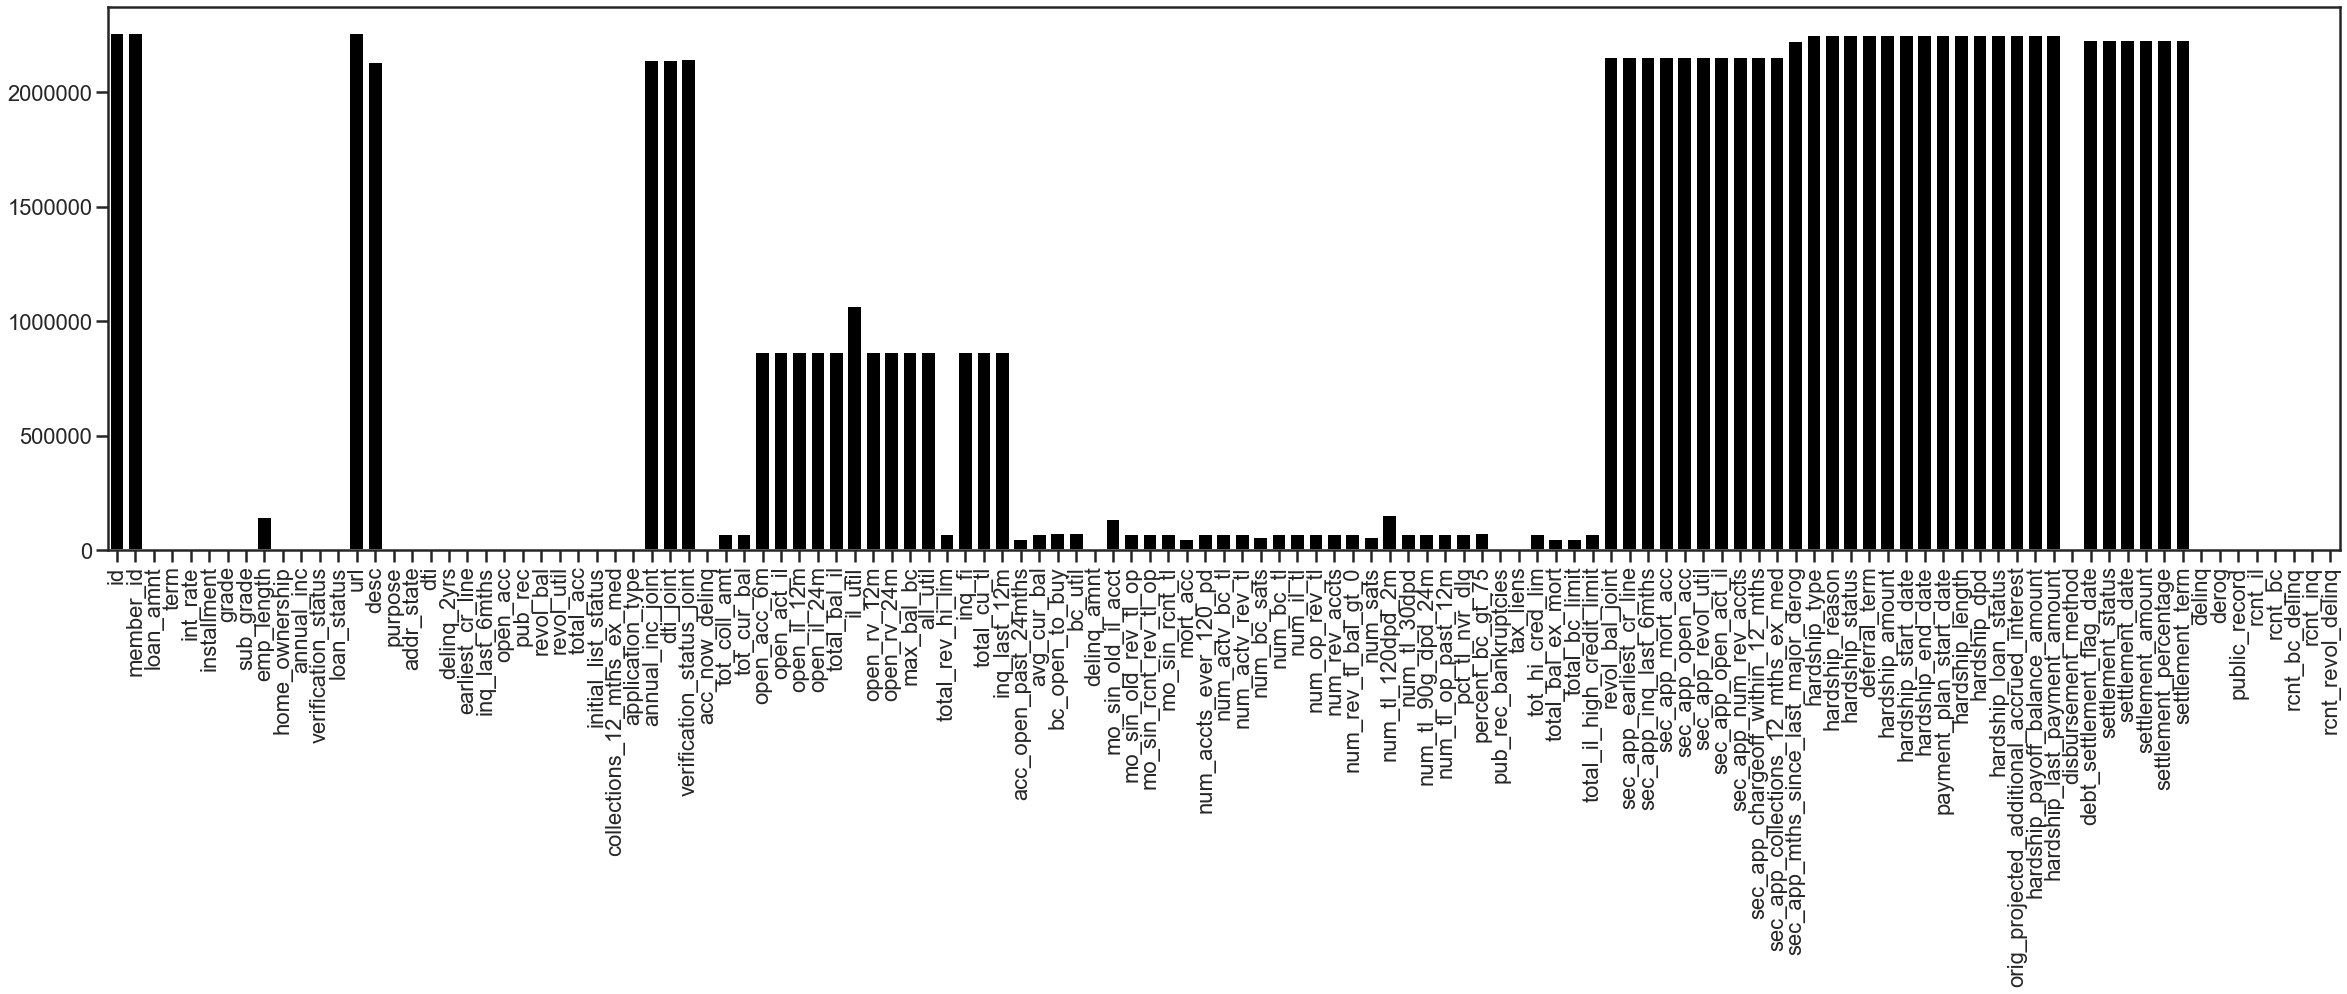

In [13]:
sns.set(context='poster',style='ticks',rc={'figure.figsize':(40,10)})
ax = sns.barplot(df_nulls.index, df_nulls.values, color='black')
plt.xticks(rotation=90)
plt.show()

In [14]:
df_nulls = pd.DataFrame(df_nulls)
df_nulls = df_nulls.rename(columns={0:'n_null'})
df_nulls['perc_null'] = df_nulls.values/len(df)

### Dropping any columns with a null percentage greated than 80%

In [15]:
bad_cols = df_nulls.loc[df_nulls['perc_null'] > 0.8].index
df_nulls = df_nulls.drop(bad_cols)
df = df.drop(bad_cols, axis=1)

### Inspecting the remaining null columns

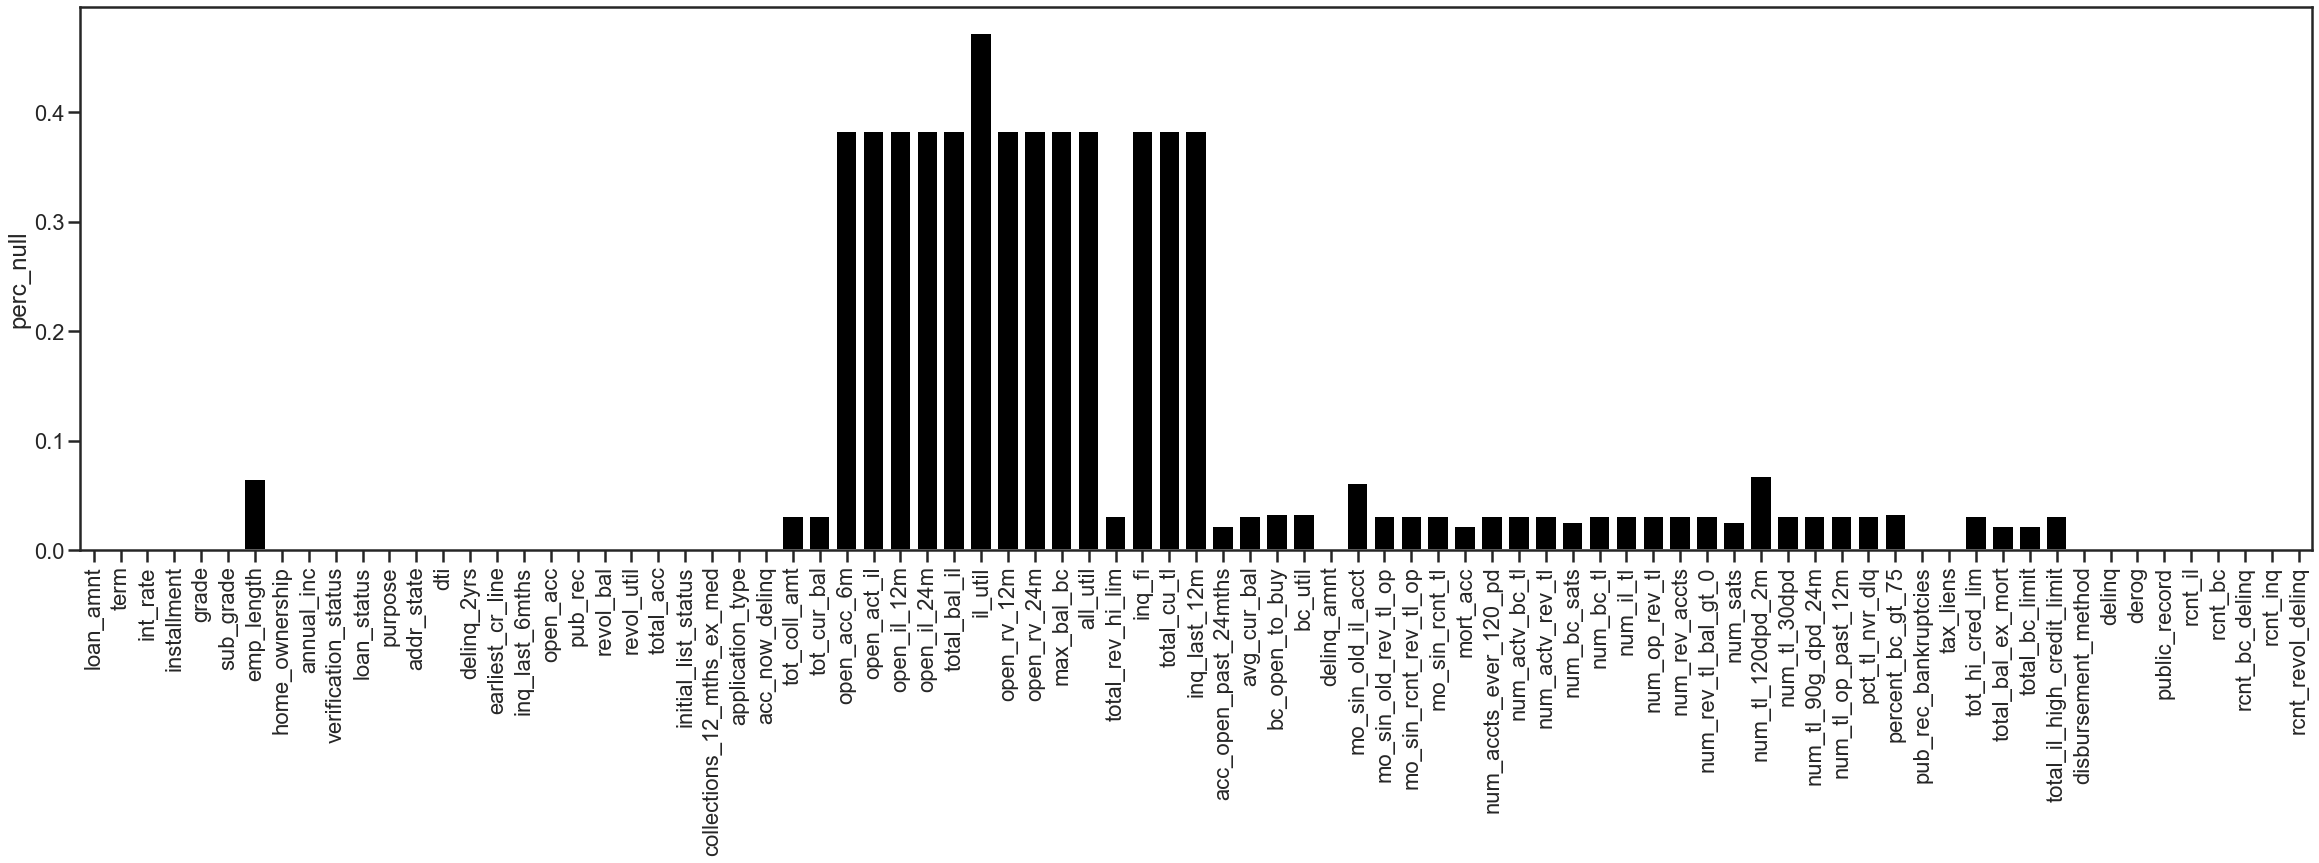

In [16]:
sns.barplot(df_nulls.index, df_nulls['perc_null'], color='Black')
plt.xticks(rotation=90)
plt.show()

### Since these columns contain a fair amount of data, there will be less data loss from dropping the null rows in this case than dropping the columns

In [17]:
df_clean = df.dropna()

### Binning the target variable into default and non-defaults. Here "charged-off" (the case where no further recouperation of funds is expected) is also being considered a default

In [18]:
def label_states(row):
    if row['loan_status'] in ['Current','Fully Paid', 'In Grace Period','Late (16-30 days)','Late (31-120 days)',\
                              'Does not meet the credit policy. Status:Fully Paid']:
        return 'Non-Default'
    if row['loan_status'] in ['Default','Charged Off','Does not meet the credit policy. Status:Charged Off']:
        return 'Default'
    
df_clean['loan_status'] = df_clean.apply(lambda row: label_states(row), axis=1)

In [19]:
df_clean['loan_status'].replace(to_replace='Non-Default', value=0, inplace=True)
df_clean['loan_status'].replace(to_replace='Default', value=1, inplace=True)

### Encoding the employee length columns from string values to numerical values:

In [20]:
df_clean.emp_length = df_clean.emp_length.replace(to_replace=['10+ years','2 years','3 years','< 1 year','1 year','4 years',\
                                                              '5 years','6 years','7 years','8 years','9 years'],\
                                                              value = [10, 2, 3, 0, 1, 4, 5, 6, 7, 8, 9])
df_clean.earliest_cr_line = pd.to_datetime(df_clean.earliest_cr_line, dayfirst=True)

### Within the columns "home_ownership","purpose", and "addr_state" there are several values with only a handful of observations, this could create problems with sub sampling later in the project so the rows containing these values are dropped:

In [21]:
rows_to_drop = df_clean.loc[(df_clean['home_ownership']=='ANY') | (df_clean['home_ownership']=='OTHER') | (df_clean['home_ownership']=='NONE')].index
df_clean.drop(index=rows_to_drop,inplace=True)

rows_to_drop = df_clean.loc[(df_clean['purpose']=='wedding') | (df_clean['purpose']=='educational') | (df_clean['purpose']=='renewable_energy')].index
df_clean.drop(index=rows_to_drop,inplace=True)

rows_to_drop = df_clean.loc[df_clean['addr_state']=='IA'].index
df_clean.drop(index=rows_to_drop,inplace=True)

In [30]:
df_clean.to_csv('lending-club-loan-data/df_clean.csv')